In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import geo_tools, nc_tools, tidetools
import xarray as xr
import glob
import datetime

%matplotlib inline

In [103]:
from matplotlib.colors import LogNorm

In [13]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
ferry_data = 'https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV1'
bathy, X, Y = tidetools.get_bathy_data(grid)
ferry = nc.Dataset(ferry_data)

In [4]:
threemonthsa = sorted(glob.glob('/ocean/vdo/MEOPAR/completed-runs/threemonthsa/test*/*1h*grid_T*'))

In [5]:
threemonthsb = sorted(glob.glob('/ocean/vdo/MEOPAR/completed-runs/threemonthsb/test*/*1h*grid_T*'))

In [53]:
threemonthsbase = sorted(glob.glob('/ocean/vdo/MEOPAR/completed-runs/threemonthbase/test*/*1h*grid_T*'))

In [113]:
mesh_mask = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
tmask = mesh_mask.variables['tmask'][:]

In [8]:
with nc_tools.scDataset(threemonthsa) as f:
    threemonthsa_sal = f.variables['vosaline'][:,1,...]
    print('salinity is done')
    threemonthsa_temp = f.variables['votemper'][:,1,...]
    print('temperature is done')
    timesa = f.variables['time_counter'][:]
    print('time is done')

salinity is done
temperature is done
time is done


In [21]:
nc.num2date(ferry.variables['s.time'][135000], ferry.variables['s.time'].units)

datetime.datetime(2017, 6, 3, 18, 0)

In [43]:
with nc_tools.scDataset(threemonthsb) as f:
    threemonthsb_sal = f.variables['vosaline'][:,1,...]
    print('salinity is done')
    threemonthsb_temp = f.variables['votemper'][:,1,...]
    print('temperature is done')
    timesb = f.variables['time_counter'][:]
    print('time is done')

salinity is done
temperature is done
time is done


In [54]:
with nc_tools.scDataset(threemonthsbase) as f:
    threemonthsbase_sal = f.variables['vosaline'][:,1,...]
    print('salinity is done')
    threemonthsbase_temp = f.variables['votemper'][:,1,...]
    print('temperature is done')
    timesbase = f.variables['time_counter'][:]
    print('time is done')

salinity is done
temperature is done
time is done


In [97]:
h = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/threemonthbase/testA/SalishSea_1h_20170307_20170316_grid_U_20170313-20170313.nc')

In [88]:
converted_timesa = nc.num2date(timesa, h.variables['time_counter'].units)
converted_timesb = nc.num2date(timesb, h.variables['time_counter'].units)
converted_timesbase = nc.num2date(timesbase, h.variables['time_counter'].units)

In [125]:
list_of_model_sals = np.array([])
list_of_model_temps = np.array([])
list_of_ferry_sals = np.array([])
list_of_ferry_temps = np.array([])
unit = ferry.variables['s.time'].units
for n in range(14500,135000):
    if ((ferry.variables['s.latitude'][n].mask == False) 
        and (ferry.variables['s.salinity'][n].mask == False)):
        Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        X, Y, land_mask = bathy.mask)
        if tmask[0,1,Yind, Xind] == 1:
            date = nc.num2date(ferry.variables['s.time'][n], unit)
            if date.minute <= 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
                index = np.argmin(np.abs(converted_timesa - date))
                delta = (date - before).seconds / 3600
                s_val = ((delta * (threemonthsa_sal[index-1, Yind, Xind])) + 
                       (1- delta)*(threemonthsa_sal[index, Yind, Xind]))
                t_val = ((delta * (threemonthsa_temp[index-1, Yind, Xind])) + 
                       (1- delta)*(threemonthsa_temp[index, Yind, Xind]))
            if date.minute > 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                       hour = (date.hour), minute = 30)
                index = np.argmin(np.abs(converted_timesa - date))
                delta = (date - before).seconds / 3600
                s_val = ((delta * (threemonthsa_sal[index, Yind, Xind])) + 
                       (1- delta)*(threemonthsa_sal[index+1, Yind, Xind]))
                t_val = ((delta * (threemonthsa_temp[index, Yind, Xind])) + 
                       (1- delta)*(threemonthsa_temp[index+1, Yind, Xind]))
            list_of_ferry_sals = np.append(list_of_ferry_sals, ferry.variables['s.salinity'][n])
            list_of_ferry_temps = np.append(list_of_ferry_temps, ferry.variables['s.temperature'][n])
            list_of_model_sals = np.append(list_of_model_sals, s_val)
            list_of_model_temps = np.append(list_of_model_temps, t_val)

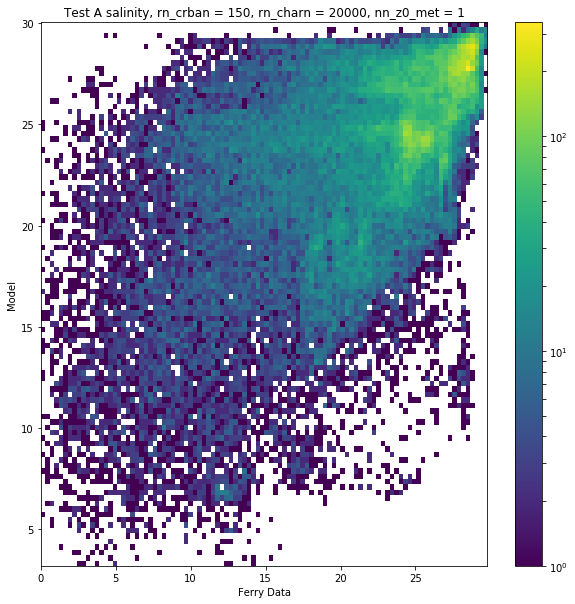

In [133]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_ferry_sals, list_of_model_sals, bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('Ferry Data')
ax.set_ylabel('Model')
ax.set_title('Test A salinity, rn_crban = 150, rn_charn = 20000, nn_z0_met = 1')

In [98]:
print('bias =  ' + str(-np.mean(list_of_ferry_sals) + np.mean(list_of_model_sals)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_sals - list_of_ferry_sals)**2) / len(list_of_model_sals))))
xbar = np.mean(list_of_ferry_sals)
print('Willmott = ' + str(1-(np.sum((list_of_model_sals - list_of_ferry_sals)**2)  / 
                             np.sum((np.abs(list_of_model_sals - xbar) + np.abs(list_of_ferry_sals - xbar))**2))))

bias =  1.94161838071
RMSE = 5.56267806197
Willmott = 0.743195687801


In [92]:
list_of_modelb_sals = np.array([])
list_of_modelb_temps = np.array([])
list_of_ferryb_sals = np.array([])
list_of_ferryb_temps = np.array([])
unit = ferry.variables['s.time'].units
for n in range(14500,135000):
    if ((ferry.variables['s.latitude'][n].mask == False) 
        and (ferry.variables['s.salinity'][n].mask == False)):
        Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        X, Y, land_mask = bathy.mask)
        date = nc.num2date(ferry.variables['s.time'][n], unit)
        if date.minute <= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            index = np.argmin(np.abs(converted_timesb - date))
            delta = (date - before).seconds / 3600
            s_val = ((delta * (threemonthsb_sal[index-1, Yind, Xind])) + 
                   (1- delta)*(threemonthsb_sal[index, Yind, Xind]))
            t_val = ((delta * (threemonthsb_temp[index-1, Yind, Xind])) + 
                   (1- delta)*(threemonthsb_temp[index, Yind, Xind]))
        if date.minute > 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            index = np.argmin(np.abs(converted_timesb - date))
            delta = (date - before).seconds / 3600
            s_val = ((delta * (threemonthsb_sal[index, Yind, Xind])) + 
                   (1- delta)*(threemonthsb_sal[index+1, Yind, Xind]))
            t_val = ((delta * (threemonthsb_temp[index, Yind, Xind])) + 
                   (1- delta)*(threemonthsb_temp[index+1, Yind, Xind]))
        list_of_ferryb_sals = np.append(list_of_ferryb_sals, 
                                        ferry.variables['s.salinity'][n])
        list_of_ferryb_temps = np.append(list_of_ferryb_temps, 
                                         ferry.variables['s.temperature'][n])
        list_of_modelb_sals = np.append(list_of_modelb_sals, s_val)
        list_of_modelb_temps = np.append(list_of_modelb_temps, t_val)

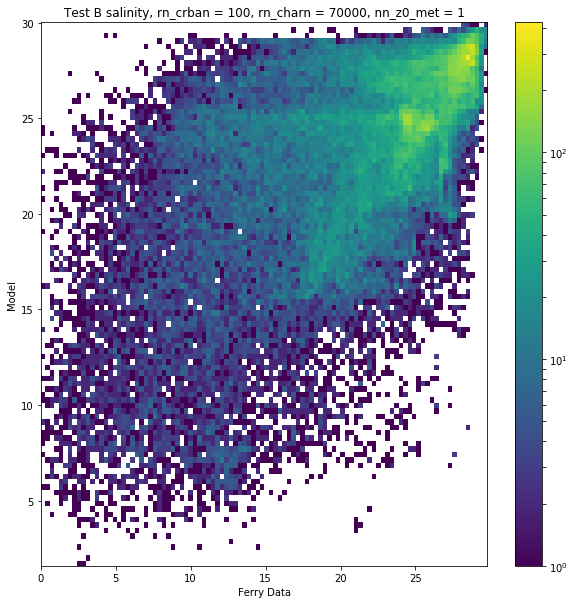

In [132]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_ferryb_sals, list_of_modelb_sals, bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('Ferry Data')
ax.set_ylabel('Model')
ax.set_title('Test B salinity, rn_crban = 100, rn_charn = 70000, nn_z0_met = 1')

In [100]:
print('bias =  ' + str(-np.mean(list_of_ferryb_sals) + np.mean(list_of_modelb_sals)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_modelb_sals - list_of_ferryb_sals)**2) / len(list_of_modelb_sals))))
xbar = np.mean(list_of_ferryb_sals)
print('Willmott = ' + str(1-(np.sum((list_of_modelb_sals - list_of_ferryb_sals)**2)  / 
                             np.sum((np.abs(list_of_modelb_sals - xbar) + np.abs(list_of_ferryb_sals - xbar))**2))))

bias =  1.79176312479
RMSE = 5.34840517666
Willmott = 0.767047886945


In [93]:
list_of_modelbase_sals = np.array([])
list_of_modelbase_temps = np.array([])
list_of_ferrybase_sals = np.array([])
list_of_ferrybase_temps = np.array([])
unit = ferry.variables['s.time'].units
for n in range(14500,135000):
    if ((ferry.variables['s.latitude'][n].mask == False) 
        and (ferry.variables['s.salinity'][n].mask == False)):
        Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        X, Y, land_mask = bathy.mask)
        date = nc.num2date(ferry.variables['s.time'][n], unit)
        if date.minute <= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            index = np.argmin(np.abs(converted_timesbase - date))
            delta = (date - before).seconds / 3600
            s_val = ((delta * (threemonthsbase_sal[index-1, Yind, Xind])) + 
                   (1- delta)*(threemonthsbase_sal[index, Yind, Xind]))
            t_val = ((delta * (threemonthsbase_temp[index-1, Yind, Xind])) + 
                   (1- delta)*(threemonthsbase_temp[index, Yind, Xind]))
        if date.minute > 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            index = np.argmin(np.abs(converted_timesbase - date))
            delta = (date - before).seconds / 3600
            s_val = ((delta * (threemonthsbase_sal[index, Yind, Xind])) + 
                   (1- delta)*(threemonthsbase_sal[index+1, Yind, Xind]))
            t_val = ((delta * (threemonthsbase_temp[index, Yind, Xind])) + 
                   (1- delta)*(threemonthsbase_temp[index+1, Yind, Xind]))
        list_of_ferrybase_sals = np.append(list_of_ferrybase_sals, 
                                           ferry.variables['s.salinity'][n])
        list_of_ferrybase_temps = np.append(list_of_ferrybase_temps, 
                                            ferry.variables['s.temperature'][n])
        list_of_modelbase_sals = np.append(list_of_modelbase_sals, s_val)
        list_of_modelbase_temps = np.append(list_of_modelbase_temps, t_val)

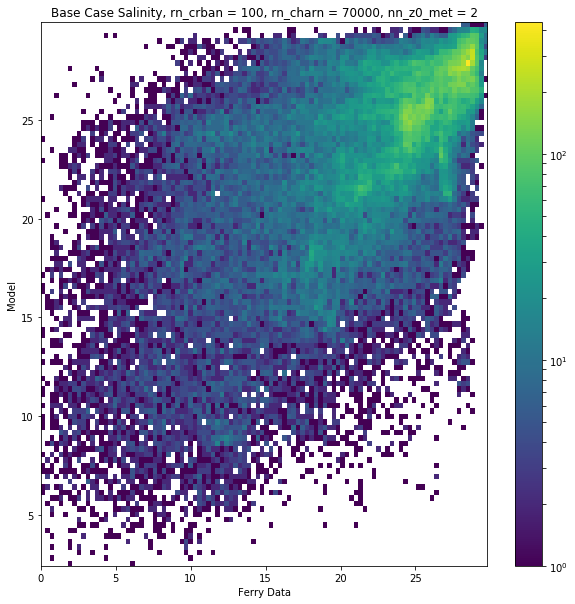

In [108]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_ferrybase_sals, 
                                list_of_modelbase_sals, bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('Ferry Data')
ax.set_ylabel('Model')
ax.set_title('Base Case Salinity, rn_crban = 100, rn_charn = 70000, nn_z0_met = 2')

In [102]:
print('bias =  ' + str(-np.mean(list_of_ferrybase_sals) + np.mean(list_of_modelbase_sals)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_modelbase_sals - list_of_ferrybase_sals)**2) 
                              / len(list_of_modelbase_sals))))
xbar = np.mean(list_of_ferrybase_sals)
print('Willmott = ' + str(1-(np.sum((list_of_modelbase_sals - list_of_ferrybase_sals)**2)  / 
                             np.sum((np.abs(list_of_modelbase_sals - xbar) 
                                     + np.abs(list_of_ferrybase_sals - xbar))**2))))

bias =  1.52707575253
RMSE = 5.24464144716
Willmott = 0.777509231541


|  Salinity         | Bias          | RMSE          | WS             |
|-----------|---------------|---------------|----------------|
| Base Case | 1.52707575253 | 5.24464144716 | 0.777509231541 |
| Test A    | 1.94161838071 | 5.56267806197 | 0.743195687801 |
| Test B    | 1.79176312479 | 5.34840517666 | 0.767047886945 |